# Classifier based

In [35]:
import os
import re
from string import punctuation

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV

In [2]:
here = os.getcwd()
project_path = os.path.dirname(here)
data_path = os.path.join(project_path, "data", "session_speech.csv")

In [3]:
data = pd.read_csv(data_path, converters={"speech":eval})
data.columns

Index(['name', 'vote', 'speech'], dtype='object')

In [4]:
data = data.explode(column="speech")
data = data[(data.speech.notna()) & (~data.vote.isin(["abstención", "ausente"]))]
data.shape

(199, 3)

In [5]:
data.vote.value_counts(normalize=True)

vote
positivo    0.557789
negativo    0.442211
Name: proportion, dtype: float64

In [6]:
le = LabelEncoder()

X = data.speech
y = le.fit_transform(data.vote)

In [7]:
def preprocess(text: str) -> str:
    text = text.lower()
    text = re.sub(rf"[{punctuation}\“\”\¿\¡\−\…]", " ", text)
    text = re.sub(r"\d+", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

## Multinomial Naive Bayes

In [8]:
nb_pipeline = Pipeline([
    (
        'tfidf',
        TfidfVectorizer(
            lowercase=True,
            preprocessor=preprocess
        )
    ),
    (
        'clf',
        MultinomialNB(),
    )])

nb_parameters = {
    "tfidf__min_df": [0.1, 0.3, 0.5, 0.7],
    "tfidf__norm": ["l1", "l2"],
    "tfidf__smooth_idf": [False, True],
    "tfidf__sublinear_tf": [False, True],
    "tfidf__min_df": [0.05, 0.1],
    "clf__alpha": [0.01, 0.1, 1.0]
}

nb_gridsearch = GridSearchCV(
    nb_pipeline,
    nb_parameters,
    scoring='f1',
    cv=5,
    return_train_score=True,
    n_jobs=-1
)
nb_gridsearch

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(preprocessor=<function preprocess at 0x7f8dc600e0e0>)),
                                       ('clf', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'clf__alpha': [0.01, 0.1, 1.0],
                         'tfidf__min_df': [0.05, 0.1],
                         'tfidf__norm': ['l1', 'l2'],
                         'tfidf__smooth_idf': [False, True],
                         'tfidf__sublinear_tf': [False, True]},
             return_train_score=True, scoring='f1')

In [9]:
nb_gridsearch.fit(X, y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(preprocessor=<function preprocess at 0x7f8dc600e0e0>)),
                                       ('clf', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'clf__alpha': [0.01, 0.1, 1.0],
                         'tfidf__min_df': [0.05, 0.1],
                         'tfidf__norm': ['l1', 'l2'],
                         'tfidf__smooth_idf': [False, True],
                         'tfidf__sublinear_tf': [False, True]},
             return_train_score=True, scoring='f1')

In [10]:
nb_gridsearch_cv_results = pd.DataFrame(nb_gridsearch.cv_results_)
param_cols = nb_gridsearch_cv_results.filter(regex="param_").columns.tolist()
nb_gridsearch_cv_results.drop(columns=param_cols, inplace=True)
nb_gridsearch_cv_results["params"] = (
    nb_gridsearch_cv_results
    .params
    .apply(lambda x: "-".join([f"{k}={v}" for k, v in x.items()]))
)
nb_gridsearch_cv_results.set_index("params", inplace=True)
nb_gridsearch_cv_results.sort_values(by="rank_test_score", inplace=True)
nb_gridsearch_cv_results = nb_gridsearch_cv_results[
    nb_gridsearch_cv_results.columns.sort_values().tolist()
]

In [29]:
split_cols = nb_gridsearch_cv_results.filter(regex=r"(split\d+\_test)").columns.to_list()
nb_gridsearch_cv_results2plot = (
    pd.concat([
        nb_gridsearch_cv_results.nlargest(3, "mean_test_score"),
        nb_gridsearch_cv_results.nsmallest(3, "std_test_score")
    ])
    .drop_duplicates(keep="first")
    .reset_index()
    .melt(
        id_vars = ["params"],
        value_vars = split_cols,
        var_name = "measure"
    )
    .merge(
        nb_gridsearch_cv_results[["mean_test_score", "std_test_score"]],
        left_on = "params", right_index = True
    )
    .reset_index(drop=True)
)

/tmp/ipykernel_20302/2350821415.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_yticklabels("F1 score")
/tmp/ipykernel_20302/2350821415.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_xticklabels([


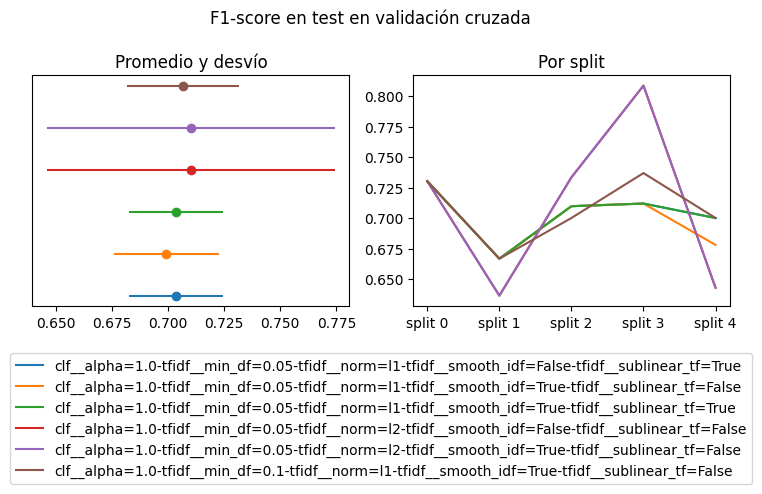

In [32]:
fig, axs = plt.subplots(1, 2, figsize=(9,3)
)
for params, df in nb_gridsearch_cv_results2plot.groupby("params"):
    _df = df[["params", "mean_test_score", "std_test_score"]].drop_duplicates(keep="first")
    axs[0].errorbar(
        x=_df.mean_test_score,
        xerr=_df.std_test_score,
        y=_df.params,
        fmt="o",
        label=params
    )
    axs[1].errorbar(
        x=df.measure,
        y=df.value,
        label=params
    )
axs[0].set_yticklabels("F1 score")
axs[0].set_yticks([])
axs[0].set_xlabel("")
axs[0].set_title("Promedio y desvío")
axs[1].set_xticklabels([
    "split {n}".format(n=re.search(r'\d+', label.get_text()).group()) for label in axs[1].get_xticklabels()
])
axs[1].set_xlabel("")
axs[1].set_title("Por split")
title = fig.suptitle("F1-score en test en validación cruzada", y=1.1)
lgd = plt.legend(loc="lower center", bbox_to_anchor=(-0.1, -0.8))

fig.savefig(
    f"{project_path}/visualizations/cls__nb_cv.png",
    bbox_extra_artists=[lgd,title], bbox_inches='tight'
)

## Logistic Regression

In [39]:
lr_pipeline = Pipeline([
    (
        'tfidf',
        TfidfVectorizer(
            lowercase=True,
            preprocessor=preprocess
        )
    ),
    (
        'clf',
        LogisticRegression(),
    )])

lr_parameters = {
    "tfidf__min_df": [0.1, 0.3, 0.5, 0.7],
    "tfidf__norm": ["l1", "l2"],
    "tfidf__smooth_idf": [False, True],
    "tfidf__sublinear_tf": [False, True],
    "tfidf__min_df": [0.05, 0.1],
    "clf__penalty": ["l1", "l2", "elasticnet"],
    "clf__C": [0.1, 0.5, 1],
    "clf__random_state": [5954]
}

lr_gridsearch = GridSearchCV(
    lr_pipeline,
    lr_parameters,
    scoring='f1',
    cv=5,
    return_train_score=True,
    n_jobs=-1
)
lr_gridsearch

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(preprocessor=<function preprocess at 0x7f8dc600e0e0>)),
                                       ('clf', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'clf__C': [0.1, 0.5, 1],
                         'clf__penalty': ['l1', 'l2', 'elasticnet'],
                         'clf__random_state': [5954],
                         'tfidf__min_df': [0.05, 0.1],
                         'tfidf__norm': ['l1', 'l2'],
                         'tfidf__smooth_idf': [False, True],
                         'tfidf__sublinear_tf': [False, True]},
             return_train_score=True, scoring='f1')

In [40]:
lr_gridsearch.fit(X, y)

/home/macarena/repos/eddc/eddc-specialization-project/venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
480 fits failed out of a total of 720.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
240 fits failed with the following error:
Traceback (most recent call last):
  File "/home/macarena/repos/eddc/eddc-specialization-project/venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/macarena/repos/eddc/eddc-specialization-project/venv/lib/python3.10/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/home/macarena/repos/ed

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(preprocessor=<function preprocess at 0x7f8dc600e0e0>)),
                                       ('clf', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'clf__C': [0.1, 0.5, 1],
                         'clf__penalty': ['l1', 'l2', 'elasticnet'],
                         'clf__random_state': [5954],
                         'tfidf__min_df': [0.05, 0.1],
                         'tfidf__norm': ['l1', 'l2'],
                         'tfidf__smooth_idf': [False, True],
                         'tfidf__sublinear_tf': [False, True]},
             return_train_score=True, scoring='f1')

In [ ]:
lr_gridsearch_cv_results = pd.DataFrame(lr_gridsearch.cv_results_)
param_cols = lr_gridsearch_cv_results.filter(regex="param_").columns.tolist()
lr_gridsearch_cv_results.drop(columns=param_cols, inplace=True)
lr_gridsearch_cv_results["params"] = (
    lr_gridsearch_cv_results
    .params
    .apply(lambda x: "-".join([f"{k}={v}" for k, v in x.items()]))
)
lr_gridsearch_cv_results.set_index("params", inplace=True)
lr_gridsearch_cv_results.sort_values(by="rank_test_score", inplace=True)
lr_gridsearch_cv_results = lr_gridsearch_cv_results[
    lr_gridsearch_cv_results.columns.sort_values().tolist()
]

In [ ]:
pipeline_FI = Pipeline([('tfidf', TfidfVectorizer(preprocessor=clean_text, 
                                               tokenizer=tokenizer, 
                                               stop_words="english", 
               
                                               ngram_range = (1,1),
                                               min_df      = best_parameters_log["tfidf__min_df"])),
                     ('clf', LogisticRegression(random_state=0, 
                                                multi_class='ovr',
                                                solver = 'lbfgs',
                                                penalty = best_parameters_log["clf__penalty"]))])

m = pipeline_FI.fit(X_train_text, y_train)

features = m[0].vocabulary_
weights  = m[1].coef_[0]